In [1]:
from gensim import corpora, models, similarities, matutils, utils
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import scipy.interpolate as interpolate
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from sklearn import metrics
from nltk import FreqDist
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import time
import nltk
import pdb
import re
import os

ModuleNotFoundError: No module named 'gensim'

In [5]:
tokenizer = RegexpTokenizer("\w+")
stop_words=set(stopwords.words('english'))
p_stemmer = PorterStemmer()

In [3]:
import pandas as pd

# DO NOT RUN THIS PART

In [4]:
subd=pd.read_hdf('Sub_data.h5', 'subs')
movd=pd.read_hdf('movbaseB.h5', 'imdb_id')

In [11]:
movd.head()

,Budget,Genre,Rating,Revenue,Runtime,Title,imdb_id
0,237000000.0,Action,7.2,2.787965e+09,162.0,Avatar,0499549
1,245000000.0,Action,7.5,2.068224e+09,136.0,Star Wars: The Force Awakens,2488496
2,220000000.0,Action,7.4,1.519558e+09,143.0,The Avengers,0848228
3,150000000.0,Action,6.5,1.513529e+09,124.0,Jurassic World,0369610
4,190000000.0,Action,7.3,1.506249e+09,137.0,Furious 7,2820852


In [58]:
subd['0848228']['StartTime']

0       00:00:27
1       00:00:30
2       00:00:31
3       00:00:37
4       00:00:40
5       00:00:47
6       00:00:50
7       00:00:57
8       00:01:00
9       00:01:03
10      00:01:22
11      00:01:23
12      00:01:56
13      00:01:58
14      00:02:04
15      00:02:07
16      00:02:09
17      00:02:11
18      00:02:13
19      00:02:14
20      00:02:15
21      00:02:17
22      00:02:19
23      00:02:20
24      00:02:22
25      00:02:24
26      00:02:26
27      00:02:28
28      00:02:31
29      00:02:32
          ...   
3366            
3367            
3368            
3369            
3370            
3371            
3372            
3373            
3374            
3375            
3376            
3377            
3378            
3379            
3380            
3381            
3382            
3383            
3384            
3385            
3386            
3387            
3388            
3389            
3390            
3391            
3392            
3393          

In [33]:
import sys
sys.getsizeof(subd) / 1024**2

982.4417181015015

In [ ]:
print('Number subs in database: {}'.format(len(subd.columns.levels[0])))
print('Here are the shitty ones:')
t0 = time.time()
for item in subd.columns.levels[0]:
    n_lines=len(subd[item][subd[item]['Line'] != ''])  #number of lines
    num_s=[item2 in ' '.join(subd[item]['Line']).strip().lower() for item2 in stop_words].count(True) #number of stop words
    if n_lines < 100 or num_s < 100:
        print('{}-{}-{} :: '.format(movd[movd.imdb_id == item]['Title'].values[0],item,num_s),end=' ')
        subd.drop(item,axis=1,level=0,inplace=True)
        subd.columns = pd.MultiIndex.from_tuples(subd.columns.to_series())
t1 = time.time()
print('Number subs after removel of shitty ones: {}'.format(len(subd.columns.levels[0])))        
print('Time elapsed cleaning: {}'.format(t1-t0))

In [ ]:
subd.to_hdf('Sub_data_cleaned.h5', 'subs', mode='w')

In [ ]:
searchw=['xb6 '] #search for certain words in the text
for item in subd.columns.levels[0]:
    num_s=[item2 in ' '.join(subd[item]['Line']).strip().lower() for item2 in searchw].count(True)
    if num_s > 0:
        print('{}-{}-{}'.format(movd[movd.imdb_id == item]['Title'].values[0],item,num_s))

In [ ]:
for key, value in raw.items():
    print('Imdb_id: {}  Length: {} Genre: {} Title: {}'
          .format(key,len(value), movd.loc[movd['imdb_id'] == key, 'Genre'].values[0]
                  , movd.loc[movd['imdb_id'] == key, 'Title'].values[0]))

# Good files start here

In [60]:
subd=pd.read_hdf('Sub_data_cleaned.h5', 'subs')
movd=pd.read_hdf('movbaseB.h5', 'imdb_id')
movd.drop_duplicates(subset='imdb_id',inplace=True)

In [67]:
len(subd.columns.levels[0])

1570

# Process Data

This involes a number of steps: <br>
1. Extracting text and time index from subtitle files<br>
2. Cleaning up the text: removing web addresses, color formatting, any user made tags (highly problematic), lowercase <br>
3. Tokenization (classification of sentence components)  <br>
4. Filtering stop words <br>
5. Filtering word length, pruning above 60% (remove very repetitive text) <br>
6. Stemming  ( removing the commoner morphological and inflexional endings ) <br>

In [6]:
raw={}  #dictionary with imdb_id as keys and string of entire script (uncleaned)
mtok={} #dictionary with imdb_id as keys and tokenized list of words for script
mltk={} #dictionary with imdb_id as keys and nltk.text.Text
fdist={} #dictionary with imdb_id as keys and nltk.probability.FreqDist
mtok_stem={}  #dictionary with imdb_id as keys and tokenized/stemmed list of words for script

for item in subd.columns.levels[0]:
        raw[item]=" ".join(subd[item]['Line']).strip().lower()
        raw[item]=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', raw[item]) #removes web addressses
        raw[item]=re.sub('<[^>]+>', '', raw[item]) #removes < crap > 
        raw[item]=re.sub('xe2\w+', '', raw[item]) #removes stuff like xe2x99xaa
        raw[item]=re.sub('xc2\w+', '', raw[item]) #removes stuff like xe2x99xaa
        raw[item]=re.sub('x9.*? ', '', raw[item]) #removes stuff like x92 
        raw[item]=re.sub('xa7.*? ', '', raw[item])
        mtok[item]=[w for w in tokenizer.tokenize(raw[item]) if not w in stop_words and len(w) > 2]   #remove stop words/2 leter
        mtok_stem[item] = [p_stemmer.stem(i) for i in mtok[item]]                            #tokenize
        #mltk[item]=nltk.Text([w for w in tokenizer.tokenize(raw[item]) if not w in stop_words])
        #fdist[item]=FreqDist(mltk[item])


In [12]:
alls=' '.join(list(raw.values()))
allst=[item for items in list(mtok.values()) for item in items]
allst_stemmed=[item for items in list(mtok_stem.values()) for item in items]


print('Total number of movies: {}'.format(len(movd)))
print('Word count:{}'.format(len(alls.split())))
print('Word count after stop word:{}'.format(len(allst)))
print('Unique tokens:{}'.format(len(set(allst_stemmed))))

Total number of movies: 1880
Word count:13098347
Word count after stop word:5940430
Unique tokens:76992


# Document-term matrix and TF-IDF transform



<img src="https://www.python-course.eu/images/bag_of_words.png" alt="Le bag of words" title="The bag of words" />

Term Frequency - raw count of word occurance <br>
Inverse Document Frequency - measure of how much information each word provides. Common terms across all documents get low weights <br>


In [13]:
texts=list(mtok_stem.values())
dictionary=corpora.Dictionary(texts)
print('Original dictionary size: {}'.format(len(dictionary.token2id)))
min_term_freq=1
max_term_fraction=0.3
dictionary.filter_extremes(no_below=min_term_freq,no_above=max_term_fraction)
print('Filtered extremes, dictionary size: {}'.format(len(dictionary.token2id)))
dictionary.save('subs_dict.dict')  #save dictionary

Original dictionary size: 76992
Filtered extremes, dictionary size: 76108


In [14]:
corpus=[dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('subs_corpus', corpus)  #save the corpus

In [15]:
#apply a Tf-Idf transform
tfidf_mod=models.TfidfModel(corpus)
corpus_tfidf=tfidf_mod[corpus]

# LSA model (Singular Value Decomposition)

-  Start with a term-document matrix, A (n documents x m terms)<br>
-  Decompose it into a product of three matrices:<br>
-  U (n documents x r topics (features)) <br>
-  S (r x r where r is the rank or strength of the topic)<br>
-  V (m terms x r topics)<br>

$$  \begin{bmatrix} 
    A_{11} & \dots & A_{1m} \\
    \vdots & \ddots & \\
    A_{n1} &        & A_{nm} 
    \end{bmatrix}                    =   \begin{bmatrix} 
    U_{11} & \dots & U_{1r} \\
    \vdots & \ddots & \\
    U_{n1} &        & U_{nr} 
    \end{bmatrix}          \times
    \begin{bmatrix} 
    S_{11} & \dots &0 \\
    \vdots & \ddots & 0\\
    0  &    0    & S_{rr} 
    \end{bmatrix}  \times        
    \begin{bmatrix} 
    V_{11} & \dots &V_{1r} \\
    \vdots & \ddots & 0\\
    V_{m1}  &    0    & V_{mr} 
    \end{bmatrix}^T  
    $$
<br>
-  doesn't provide interpretation<br>
-  unique and orthogonal<br>
-  dimensionality reduction<br>
-  latent topic extraction<br>
-  reduces doise


In [16]:
#in sequence next apply an LSA reduction
num_topics=50
t2=time.time()
lsi_mod=models.LsiModel(corpus_tfidf, id2word=dictionary,num_topics=num_topics,onepass=False,power_iters=30)
corpus_lsi=lsi_mod[corpus_tfidf]
t3=time.time()
print('Elapsed time: {}'.format(t3-t2))

Elapsed time: 97.57002997398376


In [19]:
corpora.MmCorpus.serialize('corpus_lsi', corpus)
index=similarities.MatrixSimilarity(corpus_lsi)
index.save('subs_index_LSI.index')

In [20]:
corpus_lsi_dense = matutils.corpus2dense(corpus_lsi, num_terms=lsi_mod.num_topics, num_docs=len(corpus_lsi)).transpose()

# Attempt at clustering (K-Means)

Not the ideal clustering algorithm here. <br>
-  Determines a set of K centroids <br>
-  Minimize within-cluster sum of squares (variance) <br>

$$ \sum_{x \in S_i} |\mathbf{x} - \mu_i|^2 $$

-  $\mu_i$ is the mean and $\mathbf{x}$ are points in the same cluster.

In [21]:
n_clusters=40
pred = KMeans(n_clusters=n_clusters, max_iter=100, n_init=1).fit_predict(corpus_lsi_dense)
kmean=KMeans(n_clusters=n_clusters, max_iter=100, n_init=1).fit(corpus_lsi_dense)

In [22]:
pca = PCA(n_components=23) #2-dimensional PCA
corpus_lda_dense = pca.fit_transform(corpus_lsi_dense)

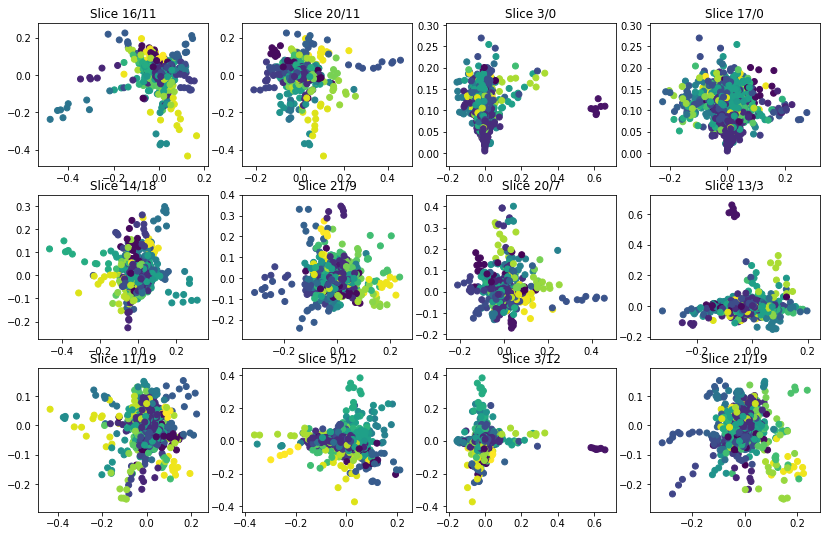

In [26]:
num_slices=22
plt.figure(figsize=(14, 9))

ar=np.random.randint(0,num_slices, size=12)
br=np.random.randint(0,num_slices, size=12)

for i in range(1,13):
    plt.subplot(3,4,int(i))
    plt.scatter(corpus_lsi_dense[:, int(ar[i-1])], corpus_lsi_dense[:, int(br[i-1])], c=pred)
    plt.title('Slice {}/{}'.format(str(ar[i-1]),str(br[i-1])))

plt.savefig('Kmeans.png',dpi=300)
plt.show()


In [27]:
def group_list(grp):
    g1=[]
    for i in range(0,pred.size):
        tid=subd.columns.levels[0][i]
        title=movd[movd.imdb_id == tid]['Title'].values[0]
        if pred[i] == grp:
            g1.append(title)
    print('Group {}: '.format(grp),end = ' ')
    for item in g1:
         print(' {}'.format(item), end=' ')
    return

In [28]:
group_list(20)

Group 20:   Halloween  Annie  Father of the Bride  The Horse Whisperer  What Dreams May Come  Vertical Limit  Halloween II  Bridesmaids  Annie 

In [29]:
group_list(17)

Group 17:   Halloween II  Tootsie  The Lost Boys  The Godfather: Part III  Space Jam  My Best Friend's Wedding  Halloween: Resurrection  Michael Jordan to the Max  Road to Perdition  Honey  The Haunted Mansion  Halloween  Click  The Blind Side  The Rite 

In [31]:
group_list(23)

Group 23:   Star Wars  The Empire Strikes Back  Return of the Jedi  Star Wars: Episode I - The Phantom Menace  Star Wars: Episode II - Attack of the Clones  Star Wars: Episode III - Revenge of the Sith  Star Wars: The Force Awakens 

In [381]:
group_list(19)

Group 19:   Scream  Scream 2  Scream 3  Ice Age  Ice Age: The Meltdown  Ice Age: Dawn of the Dinosaurs  Scream 4  Ice Age: Continental Drift  Ice Age: Collision Course 

# Search function / Cosine similarity 


<img src="http://blog.christianperone.com/wp-content/uploads/2013/09/Dot_Product.png" alt="Cosine Similarity" title="Cosine" />


Movies are represented as vectors in k-features space. We measure the degree of similarity by taking the normalized dot product.<br>

$$ \cos \theta = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|} $$


Vectors that point in the same direction are similar, for a cosine of the angle near 1.

In [32]:
def search_movie_else(search_name):
    id=False
    for item in movd['Title']:
        if search_name in item.lower():
            #print(movd[movd['Title']==item]['imdb_id'].values[0],item)
            id=movd[movd['Title']==item]['imdb_id'].values[0]
    return id  

def search_movie(query):
    id=False
    tit_id = dict(zip(list(movd['imdb_id'].values), list(movd['Title'].values.astype('str'))))
    print()
    print('Possible titles:')
    search_results=[]
    i=1
    for key,item in tit_id.items():
        
        if query in item.lower():
            search_results.append(key) 
            search_results.append(item)
            print(i,item)
            i = i+1
            
    #print(search_results)      
    
    if len(search_results)>2:
        num_t=input('Multiple found. Which one?')
        id=search_results[int(num_t)*2-2]
    else:
        id=search_results[0]
    return id

def find_closest_to(num):
    query=input('Which movie? ')
    movie_id=search_movie(query)
        
    if movie_id and movie_id in subd.columns.levels[0].values:
        movie=mtok_stem[movie_id]
        vec_movie=lsi_mod[tfidf_mod[dictionary.doc2bow(movie)]]
        index.num_best = num
        sims=index[vec_movie]
        
        print('------Similar titles to: {}------'.format(movd[movd.imdb_id == movie_id]['Title'].values[0]))
        print()
        i=1
        for item in sims:
            tid=subd.columns.levels[0][item[0]]
            title=movd[movd.imdb_id == tid]['Title'].values[0]
            print('   {}.{}'.format(i, title))
            i = i+1        
    else:
        print('Chosing the last one... Ooops. Dont have it bro.')

def find_closest(num):
    imdb_id_random=subd.columns.levels[0][np.random.randint(0,len(subd.columns.levels[0])-1)]
    #query=mtok[imdb_id_random]
    #query=search_movie(input('Name a movie:'))
    #print(query)
    if imdb_id_random:
        movie=mtok[imdb_id_random]
        vec_movie=lda_mod[dictionary.doc2bow(movie)]
        index.num_best = num
        sims=index[vec_movie]
        
        
        print('------Similar titles to: {}------'.format(movd[movd.imdb_id == imdb_id_random]['Title'].values[0]))
        print()
        i=1
        for item in sims:
            tid=subd.columns.levels[0][item[0]]
            title=movd[movd.imdb_id == tid]['Title'].values[0]
            print('{}.{}'.format(i, title))
            i = i+1        

In [60]:
find_closest_to(20)

Which movie? avengers

Possible titles:
1 The Avengers
2 Avengers: Age of Ultron
Multiple found. Which one?1
------Similar titles to: The Avengers------

   1.The Avengers
   2.Avengers: Age of Ultron
   3.Iron Man 2
   4.Captain America: Civil War
   5.Iron Man
   6.Iron Man 3
   7.Captain America: The First Avenger
   8.Saturday Night Fever
   9.Captain America: The Winter Soldier
   10.Valley of the Dolls
   11.Spider-Man: Homecoming
   12.Thor
   13.An American Tail
   14.Thor: The Dark World
   15.Valkyrie
   16.Brooklyn
   17.West Side Story
   18.Argo
   19.Spawn
   20.Ant-Man


# Movie vector time evolution - The fun stuff

Movies are intrinsically **markovian** in nature - time ordered products of words. How to incorporate time? <br>
<br>

-  look at how the vectors in feature space evolve
-  split up movie into equal length chunks
-  project chunks into features space
-  extract time dependent information: velocities, feature transition, etc..

In [44]:
def create_plot(y_ar,num_feature,movie_num):
    x=np.linspace(0,len(y_ar)-1,len(y_ar))
    y=y_ar[:,num_feature]
    t, c, k = interpolate.splrep(x, y, s=0, k=3)
    N = 200
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    
    #norm=mpl.colors.Normalize(vmin=0,vmax=50)
    #cmap=cm.jet
    #c_map=cmap(norm(num_feature))
    #color =c_map
    
    #plt.plot(x, y, 'bo', label='Original points')
    if movie_num ==1:
        plt.plot(xx, spline(xx),  label='Ft.#{} Mov.#{}'.format(num_feature,movie_num))
    if movie_num ==2:
        plt.plot(xx, spline(xx), '-.',  label='Ft.#{} Mov.#{}'.format(num_feature,movie_num))
    return
    
def movie_vectorize(movie):
    n=80 #number of word chunks at one time
    vec_movie=lsi_mod[tfidf_mod[dictionary.doc2bow(movie)]]
    chunk_movie=[movie[i:i + n] for i in range(0, len(movie), n)]
    chunk_movie_vec=[lsi_mod[tfidf_mod[dictionary.doc2bow(text)]] for text in chunk_movie]
    vec_array=matutils.corpus2dense(chunk_movie_vec,num_terms=lsi_mod.num_topics).transpose()
    
    #for item in vec_movie:
    #   print(item)
    
    return vec_array
    
    
def pick_top_features(vec_array,num_feats):    
    
    feat_prevalence=[vec_array[:,i].sum() for i in range(0,len(vec_array[1,:]))]   
    #counts which features shows up most by integrating the absolute value
    
    top_features=sorted(range(len(feat_prevalence)), key=lambda i: -feat_prevalence[i])[0:num_feats]
    #picks index of most prominent features
    #pdb.set_trace()
    return top_features
    
def plot_features(num_feats):
    
    query=input('Which movie? ')
    movie_id=search_movie(query)
    title=movd[movd.imdb_id == movie_id]['Title'].values[0]
    print(title)
    
    vec_array=movie_vectorize(mtok[movie_id])  #vectorizes movie
    
    top_features=pick_top_features(vec_array,num_feats)  #returns a list of the top features
    
    
    plt.figure(figsize=(16, 4))   
    plt.title('Time evolution of features in movie: {}'.format(title))
    plt.ylabel('Feature Strength')
    plt.xlabel('Time')
    plt.xticks([])
  
    for item in top_features:
        create_plot(vec_array,item,1)
       
    #plt.grid()
    #plt.legend(loc='best')
    plt.savefig('TEVOL2.png',dpi=300)
    plt.show()
    
    
def compare_features(num_feats):
    query1=input('Movie 1?')
    query2=input('Movie 2?')
    
    movie1_id=search_movie(query1)
    movie2_id=search_movie(query2)
    
    movie1=mtok_stem[movie1_id]
    movie2=mtok_stem[movie2_id]
    
    title1=movd[movd.imdb_id == movie1_id]['Title'].values[0]
    title2=movd[movd.imdb_id == movie2_id]['Title'].values[0]
    
    vec_array1=movie_vectorize(movie1)  #vectorizes movie
    vec_array2=movie_vectorize(movie2)  #vectorizes movie
    
    top_features1=pick_top_features(vec_array1,10)  #returns a list of the 20 top features
    top_features2=pick_top_features(vec_array2,10)  #returns a list of the 20 top features
    
    common_feats=list(set(top_features1).intersection(top_features2))
    
    
    
    if not common_feats: #if its empty - no common features
        print('No common features.')
    else: # if they do have common features
        print()
        print('{} and {} have {} common features.'.format(title1,title2,len(common_feats)))
        plt.figure(figsize=(16, 4))   
        plt.title('Common features time evolution in {}(1) & {}(2)'.format(title1,title2))
        plt.ylabel('Feature Strength')
        plt.xlabel('Time')
        plt.xticks([])

        for item in common_feats[0:num_feats]:
            create_plot(vec_array1,item,1)
            create_plot(vec_array2,item,2)

        plt.grid()
        plt.legend(loc='best')
        plt.savefig('TEVOL4.png',dpi=300)
        plt.show()
        

Which movie? wolf of wall

Possible titles:
1 The Wolf of Wall Street
The Wolf of Wall Street


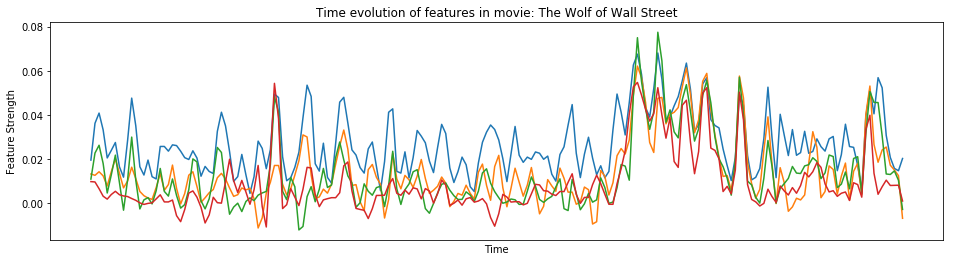

In [46]:
plot_features(4)

Movie 1?wolf of wall
Movie 2?social net

Possible titles:
1 The Wolf of Wall Street

Possible titles:
1 The Social Network

The Wolf of Wall Street and The Social Network have 2 common features.


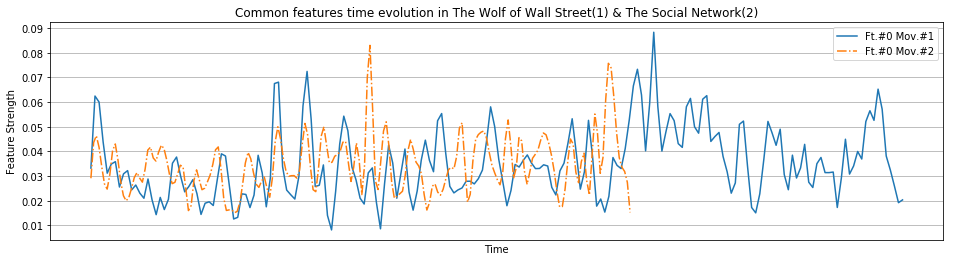

In [47]:
compare_features(1)

Which movie? harry

Possible titles:
1 Harry Potter and the Deathly Hallows: Part 2
2 Harry Potter and the Philosopher's Stone
3 Harry Potter and the Deathly Hallows: Part 1
4 Harry Potter and the Order of the Phoenix
5 Harry Potter and the Half-Blood Prince
6 Harry Potter and the Goblet of Fire
7 Harry Potter and the Chamber of Secrets
8 Harry Potter and the Prisoner of Azkaban
9 Who Is Harry Nilsson (And Why Is Everybody Tal..
10 When Harry Met Sally...
Multiple found. Which one?3
Harry Potter and the Deathly Hallows: Part 1


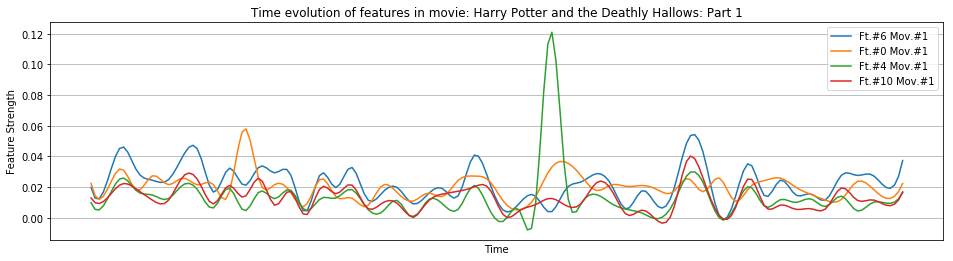

In [330]:
plot_features(4)

In [334]:
lsi_mod.print_topic(3, topn=15)

'-0.556*"harri" + -0.266*"potter" + -0.210*"dumbledor" + -0.207*"hermion" + 0.188*"jake" + -0.164*"ron" + -0.163*"peter" + -0.146*"hagrid" + -0.135*"voldemort" + -0.126*"spider" + -0.117*"hogwart" + -0.111*"wand" + -0.108*"snape" + -0.102*"professor" + -0.092*"dobbi"'

In [228]:
for key, item in mtok.items():
    if len(item) >7000 and len(item) <8000:
        print(len(item),movd[movd.imdb_id ==key].Title.values.astype(str))

7739 ['My Fair Lady']
7751 ['Crumb']
7664 ['Pulp Fiction']
7094 ['The American President']
7084 ['Apollo 13']
7270 ['Sleepers']
7005 ['A Time to Kill']
7004 ['Pearl Harbor']
7557 ['Catch Me If You Can']
7692 ['Meet the Fockers']
7074 ['Dig!']
7299 ['Wedding Crashers']
7980 ['The 40 Year Old Virgin']
7109 ["Dave Chappelle's Block Party"]
7886 ['49 Up']
7226 ['Wall Street: Money Never Sleeps']
7483 ['Couples Retreat']
7485 ['The Social Network']
7224 ['Ghostbusters']
7010 ['Forks Over Knives']
7336 ['The Big Short']
7475 ["We're the Millers"]
7526 ['We Steal Secrets: The Story of WikiLeaks']
7043 ['Gone Girl']
7248 ['22 Jump Street']
7488 ['The Heat']
7648 ["The Internet's Own Boy: The Story of Aaron Swartz"]
7583 ['Steve Jobs: The Man in the Machine']
7529 ['Supersonic']
